# Denoising Diffusion Implicit Models - DDIM

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
from diffusers import UNet2DModel, DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler

## Diffusers DDPM Scheduler

In [ ]:
class UNet(UNet2DModel):
    ...

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "19_ddpm_v3_lincos_10.pkl")

In [ ]:
DDPMScheduler?

Init signature:
DDPMScheduler(
    num_train_timesteps: int = 1000,
    beta_start: float = 0.0001,
    beta_end: float = 0.02,
    beta_schedule: str = 'linear',
    trained_betas: Union[numpy.ndarray, List[float], NoneType] = None,
    variance_type: str = 'fixed_small',
    clip_sample: bool = True,
    prediction_type: str = 'epsilon',
    thresholding: bool = False,
    dynamic_thresholding_ratio: float = 0.995,
    clip_sample_range: float = 1.0,
    sample_max_value: float = 1.0,
    timestep_spacing: str = 'leading',
    steps_offset: int = 0,
)
Docstring:     
`DDPMScheduler` explores the connections between denoising score matching and Langevin dynamics sampling.

This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
methods the library implements for all schedulers such as loading and saving.

Args:
    num_train_timesteps (`int`, defaults to 1000):
        The number of diffusion steps to train the model.
    bet

In [ ]:
scheduler = DDPMScheduler(beta_start=0.00001, beta_end=0.01, clip_sample_range=0.5, variance_type="fixed_large")

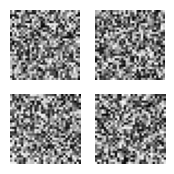

In [ ]:
xb = torch.rand((4, 1, 32, 32)).cuda()
show_images(xb, imsize=1);

In [ ]:
scheduler.step?

Signature:
scheduler.step(
    model_output: torch.FloatTensor,
    timestep: int,
    sample: torch.FloatTensor,
    generator=None,
    return_dict: bool = True,
) -> Union[diffusers.schedulers.scheduling_ddpm.DDPMSchedulerOutput, Tuple]
Docstring:
Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
process from the learned model outputs (most often the predicted noise).

Args:
    model_output (`torch.FloatTensor`):
        The direct output from learned diffusion model.
    timestep (`float`):
        The current discrete timestep in the diffusion chain.
    sample (`torch.FloatTensor`):
        A current instance of a sample created by the diffusion process.
    generator (`torch.Generator`, *optional*):
        A random number generator.
    return_dict (`bool`, *optional*, defaults to `True`):
        Whether or not to return a [`~schedulers.scheduling_ddpm.DDPMSchedulerOutput`] or `tuple`.

Returns:
    [`~schedulers.schedu

In [ ]:
with torch.no_grad():
    t_batch = torch.full((xb.shape[0],), 999, dtype=torch.int64).cuda()
    noise = model(xb, t_batch).sample

In [ ]:
next_xb = scheduler.step(noise, 999, xb)

In [ ]:
next_xb.keys()

odict_keys(['prev_sample', 'pred_original_sample'])

In [ ]:
from fastprogress import progress_bar

In [ ]:
bs = 128

In [ ]:
set_seed(1103, False)

In [ ]:
%%time
xb = torch.randn((bs, 1, 32, 32)).cuda()
with torch.no_grad():
    for t in progress_bar(scheduler.timesteps):
        t_batch = torch.full((xb.shape[0],), t, dtype=torch.int64).cuda()
        noise = model(xb, t_batch).sample
        xb = scheduler.step(noise, t, xb).prev_sample

CPU times: user 2min 23s, sys: 1.03 s, total: 2min 24s
Wall time: 2min 24s


In [ ]:
xb.min(), xb.max()

(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

In [ ]:
final = (xb * 2)

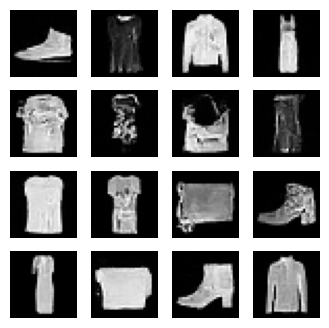

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)


dls2 = DataLoaders.from_dd(dst2, bs)

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(223.600341796875, 0.09872913360595703)

In [ ]:
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
xb.min(), xb.max()

(tensor(-0.5000), tensor(0.5000))

In [ ]:
image_eval.fid(xb * 2), image_eval.kid(xb * 2)

(320.48651123046875, 0.5210719108581543)

## Diffusers DDIM Scheduler

In [ ]:
DDIMScheduler?

Init signature:
DDIMScheduler(
    num_train_timesteps: int = 1000,
    beta_start: float = 0.0001,
    beta_end: float = 0.02,
    beta_schedule: str = 'linear',
    trained_betas: Union[numpy.ndarray, List[float], NoneType] = None,
    clip_sample: bool = True,
    set_alpha_to_one: bool = True,
    steps_offset: int = 0,
    prediction_type: str = 'epsilon',
    thresholding: bool = False,
    dynamic_thresholding_ratio: float = 0.995,
    clip_sample_range: float = 1.0,
    sample_max_value: float = 1.0,
    timestep_spacing: str = 'leading',
    rescale_betas_zero_snr: bool = False,
)
Docstring:     
`DDIMScheduler` extends the denoising procedure introduced in denoising diffusion probabilistic models (DDPMs) with
non-Markovian guidance.

This model inherits from [`SchedulerMixin`] and [`ConfigMixin`]. Check the superclass documentation for the generic
methods the library implements for all schedulers such as loading and saving.

Args:
    num_train_timesteps (`int`, defaults to 1

In [ ]:
scheduler = DDIMScheduler(beta_start=0.00001, beta_end=0.01, clip_sample_range=0.5, num_train_timesteps=1000)
scheduler.set_timesteps(333)

In [ ]:
scheduler.step?

Signature:
scheduler.step(
    model_output: torch.FloatTensor,
    timestep: int,
    sample: torch.FloatTensor,
    eta: float = 0.0,
    use_clipped_model_output: bool = False,
    generator=None,
    variance_noise: Optional[torch.FloatTensor] = None,
    return_dict: bool = True,
) -> Union[diffusers.schedulers.scheduling_ddim.DDIMSchedulerOutput, Tuple]
Docstring:
Predict the sample from the previous timestep by reversing the SDE. This function propagates the diffusion
process from the learned model outputs (most often the predicted noise).

Args:
    model_output (`torch.FloatTensor`):
        The direct output from learned diffusion model.
    timestep (`float`):
        The current discrete timestep in the diffusion chain.
    sample (`torch.FloatTensor`):
        A current instance of a sample created by the diffusion process.
    eta (`float`):
        The weight of noise for added noise in diffusion step.
    use_clipped_model_output (`bool`, defaults to `False`):
        I

In [ ]:
def diff_sample(model, sz, sched, **kwargs):
    xb = torch.randn(sz).cuda()
    for t in progress_bar(scheduler.timesteps):
        with torch.no_grad():
            t_batch = torch.full((xb.shape[0],), t, dtype=torch.int64).cuda()
            noise = model(xb, t_batch).sample
        xb = sched.step(noise, t, xb, **kwargs).prev_sample
    return xb

In [ ]:
generated.min(), generated.max()

(tensor(-0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))

In [ ]:
final = (generated * 2)

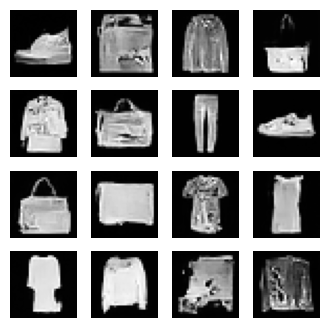

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(229.967529296875, 0.16600799560546875)

In [ ]:
scheduler.set_timesteps(160)
%time generated = diff_sample(model, (bs, 1, 32, 32), scheduler)
final = generated * 2

CPU times: user 14.4 s, sys: 190 ms, total: 14.6 s
Wall time: 14.6 s


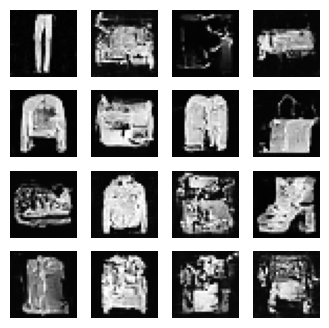

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(417.75048828125, 1.5232644081115723)

In [ ]:
scheduler.set_timesteps(80)
%time generated = diff_sample(model, (bs, 1, 32, 32), scheduler)
final = generated * 2

CPU times: user 7.39 s, sys: 90.5 ms, total: 7.48 s
Wall time: 7.47 s


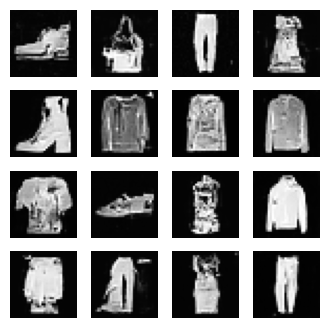

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(227.8470458984375, 0.3437814712524414)

In [ ]:
scheduler.set_timesteps(40)
%time generated = diff_sample(model, (bs, 1, 32, 32), scheduler)
final = generated * 2

CPU times: user 3.66 s, sys: 395 µs, total: 3.66 s
Wall time: 3.65 s


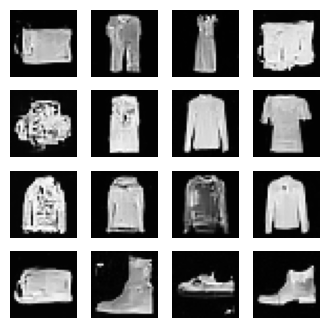

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(220.927734375, 0.08289861679077148)

## Implementing DDIM

In [ ]:
class Schedule:
    def __init__(self, alphas, betas, alphas_bar, sigmas, n_steps):
        fc.store_attr()

def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    betas = torch.linspace(beta_min, beta_max, n_steps)
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, 0)
    sigmas = betas.sqrt()
    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

schedule = linear_sched(beta_min=0.00001, beta_max=0.01)

In [ ]:
set_seed(1103, False)

https://arxiv.org/abs/2010.02502

In [ ]:
def ddim_step(x_t, t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = (x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device) if t > 0 else 0
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
def sample(f, model, sz, n_steps, schedule=schedule, skips=1, eta=1.):
    ts = list(range(0, n_steps, skips))[::-1]
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for idx, t in enumerate(progress_bar(ts)):
            t_batch = torch.full((bs,), t, dtype=torch.int64, device=device)
            noise_pred = model(x, t_batch).sample

            alpha_bar_t = schedule.alphas_bar[t]
            alpha_bar_t_minus_1 = schedule.alphas_bar[ts[idx + 1]] if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, t, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            process.append(to_cpu(x))
    return process

In [ ]:
%time generated = sample(ddim_step, model, (bs, 1, 32, 32), 1000, skips=3)
final = generated[-1] * 2

CPU times: user 3min 10s, sys: 566 ms, total: 3min 11s
Wall time: 3min 11s


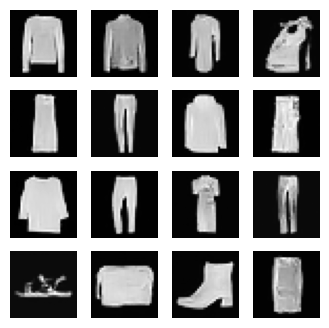

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(35.6588134765625, 0.06236743927001953)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
frames = list(range(len(generated))) + [len(generated)-1]*10

def _show(i):
    show_image(generated[frames[i]][-1] * 2, ax=ax)
animation = FuncAnimation(fig, _show, frames=len(frames))

display(HTML(animation.to_html5_video()))
plt.close()

In [ ]:
%time generated = sample(ddim_step, model, (bs, 1, 32, 32), 1000, skips=25)
final = generated[-1] * 2

CPU times: user 18.4 s, sys: 89.9 ms, total: 18.5 s
Wall time: 18.5 s


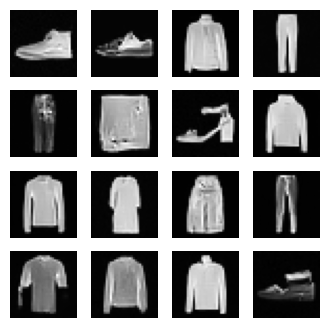

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(39.127685546875, 0.07230186462402344)

In [ ]:
%time generated = sample(ddim_step, model, (bs, 1, 32, 32), 1000, skips=100)
final = generated[-1] * 2

CPU times: user 5.76 s, sys: 9.97 ms, total: 5.77 s
Wall time: 5.77 s


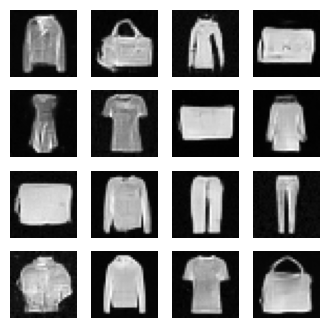

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(61.254150390625, 0.23556137084960938)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,4))
frames = list(range(len(generated))) + [len(generated)-1]*10

def _show(i):
    show_image(generated[frames[i]][-1] * 2, ax=ax)
animation = FuncAnimation(fig, _show, frames=len(frames))

display(HTML(animation.to_html5_video()))
plt.close()

In [ ]:
%time generated = sample(ddim_step, model, (bs, 1, 32, 32), 1000, skips=200)
final = generated[-1] * 2

CPU times: user 1.09 s, sys: 25 µs, total: 1.09 s
Wall time: 1.09 s


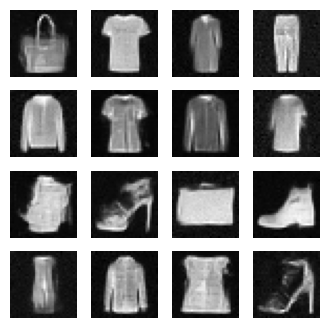

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(122.9837646484375, 0.5619702339172363)